In [24]:
import os
import sys
import subprocess
from pathlib import Path

repo_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

sys.path.append(repo_root)

In [25]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import pandas as pd
import pickle

from matplotlib import pyplot as plt

import params, utils, data_loader
from modules import helpers, training
from modules.nn import mlp, pca

In [26]:
import importlib
importlib.reload(utils)
importlib.reload(data_loader)

importlib.reload(training)

importlib.reload(mlp)
importlib.reload(pca)

<module 'modules.nn.pca' from '/Users/vinhtran/Data/MIT Classes/Spring 2025/8.13/mit-jlab-sp25/modules/nn/pca.py'>

In [27]:
helpers.set_plot_configs()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [28]:
MC_dir = '../HiggsTo4L/MC/'
data_dir = '../HiggsTo4L/data/'

In [29]:
print('Higgs:')
mc_higgs = utils.FourLeptonsReader([
    MC_dir + 'higgs2011.csv',
    MC_dir + 'higgs2012.csv'
],scalers=params.scales_higgs)
mc_higgs_dfs = mc_higgs.apply_basic_cuts(mc_higgs.dfs,show_cut_info=True)

print('ZZ:')
mc_zz = utils.FourLeptonsReader([
    MC_dir + 'zzto4mu2011.csv',
    MC_dir + 'zzto2mu2e2011.csv',
    MC_dir + 'zzto4e2011.csv',

    MC_dir + 'zzto4mu2012.csv',
    MC_dir + 'zzto2mu2e2012.csv',
    MC_dir + 'zzto4e2012.csv',
],scalers=params.scales_zz)
mc_zz_dfs = mc_zz.apply_basic_cuts(mc_zz.dfs,show_cut_info=True)

print('Drell-Yan:')
mc_dy = utils.FourLeptonsReader([
    MC_dir + 'dy1050_2011.csv',
    MC_dir + 'dy50_2011.csv',
    MC_dir + 'dy1050_2012.csv',
    MC_dir + 'dy50_2012.csv'
],scalers=params.scales_dy)
mc_dy_dfs = mc_dy.apply_basic_cuts(mc_dy.dfs,show_cut_info=True)

print('tt:')
mc_tt = utils.FourLeptonsReader([
    MC_dir + 'ttbar2011.csv',
    MC_dir + 'ttbar2012.csv'
],scalers=params.scales_tt)
mc_tt_dfs = mc_tt.apply_basic_cuts(mc_tt.dfs,show_cut_info=True)

Higgs:
 Conservation cut: 50542 events passed out of 52248 (97%)
 Leptons cut: 44320 events passed out of 50542 (88%)
 Z cut: 41818 events passed out of 44320 (94%)
 Conservation cut: 39353 events passed out of 40530 (97%)
 Leptons cut: 35855 events passed out of 39353 (91%)
 Z cut: 33996 events passed out of 35855 (95%)
ZZ:
 Conservation cut: 207439 events passed out of 209504 (99%)
 Leptons cut: 162016 events passed out of 207439 (78%)
 Z cut: 123286 events passed out of 162016 (76%)
 Conservation cut: 152367 events passed out of 155454 (98%)
 Leptons cut: 110224 events passed out of 152367 (72%)
 Z cut: 68099 events passed out of 110224 (62%)
 Conservation cut: 140811 events passed out of 144999 (97%)
 Leptons cut: 93161 events passed out of 140811 (66%)
 Z cut: 78064 events passed out of 93161 (84%)
 Conservation cut: 182153 events passed out of 183843 (99%)
 Leptons cut: 148678 events passed out of 182153 (82%)
 Z cut: 116017 events passed out of 148678 (78%)
 Conservation cut: 12

In [30]:
bins = np.linspace(50,200,101)
bin_centers = (bins[1:] + bins[:-1]) / 2
bin_width = bins[1] - bins[0]

higgs_hist = mc_higgs.get_histogram(mc_higgs_dfs, 'm4l', bins) 
zz_hist = mc_zz.get_histogram(mc_zz_dfs, 'm4l', bins)
dy_hist = mc_dy.get_histogram(mc_dy_dfs, 'm4l', bins)
tt_hist = mc_tt.get_histogram(mc_tt_dfs, 'm4l', bins)

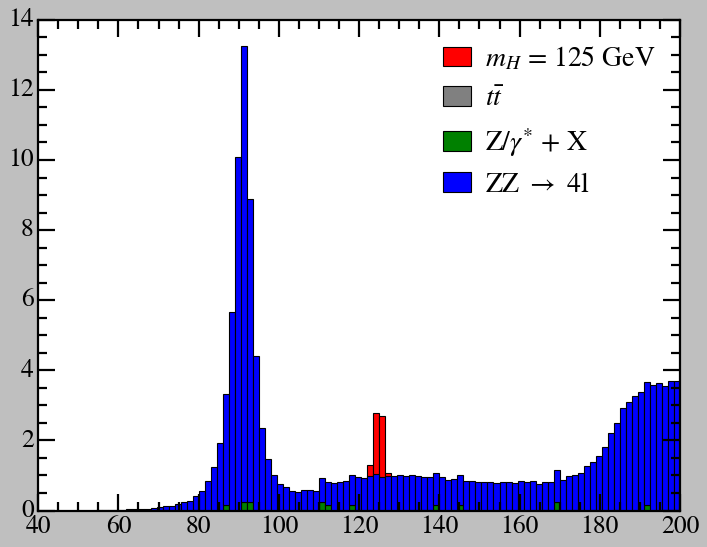

In [31]:
fig, ax = plt.subplots(figsize=(9,7))

stack = ax.bar(bin_centers, higgs_hist, align='center', width=bin_width, label=r'$m_{H}$ = 125 GeV', color='red')
stack = ax.bar(bin_centers, tt_hist, align='center', width=bin_width, label=r'$t\bar{t}$', color='grey')
stack = ax.bar(bin_centers, dy_hist, align='center', width=bin_width, label=r'Z/$\gamma^{*}$ + X', color='green', bottom=tt_hist)
stack = ax.bar(bin_centers, zz_hist, align='center', width=bin_width, label=r'ZZ $\rightarrow$ 4l', color='blue', bottom=tt_hist+dy_hist)

ax.legend(loc='upper right', frameon=False, ncol=1, handletextpad=0.5, handlelength=1.0, columnspacing=0.5)

plt.tight_layout()
plt.show()

In [32]:
class FourLeptonsPCA(pca.PCA):
    def __init__(self, dfs, event_nums, fields,
                 higgs_dfs_num=2):
        self.dfs = dfs
        self.event_nums = event_nums
        self.fields = fields

        self.higgs_dfs_num = higgs_dfs_num

    def _subsample(self, df, n):
        idx = np.random.choice(len(df), n, replace=False)
        return df.iloc[idx]
    
    def get_pca(self):
        X = pd.concat([
            self._subsample(df, min(self.event_nums)) for df in self.dfs
        ])[self.fields].to_numpy()

        X = torch.from_numpy(X)

        X_norm, X_mean, X_std = self._standardize(X)
        X_pca, V = self._perform_pca(X_norm)

        higgs_zz_idx = min(self.event_nums) * self.higgs_dfs_num

        higgs_pca = X_pca[:higgs_zz_idx]
        zz_pca = X_pca[higgs_zz_idx:]

        return higgs_pca, zz_pca

In [33]:
mc_all_dfs = mc_higgs_dfs + mc_zz_dfs
mc_all_event_nums = [
    len(df) for df in mc_all_dfs
]

fields = [
    'E1', 'px1', 'py1', 'pz1',
    'E2', 'px2', 'py2', 'pz2',
    'E3', 'px3', 'py3', 'pz3',
    'E4', 'px4', 'py4', 'pz4',
]

mc_all_pca = FourLeptonsPCA(mc_all_dfs, mc_all_event_nums, fields)
higgs_pca, zz_pca = mc_all_pca.get_pca()

In [34]:
if False:
    for pca_idx in range(16):
        print('PC', pca_idx+1)

        bins = np.linspace(-3,3,101)
        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        higgs_hist, _, _ = plt.hist(higgs_pca[:,pca_idx], bins=bins, histtype='step', color='red',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(higgs_hist) * bin_width, color='red', lw=2, ls='--')

        zz_hist, _, _ = plt.hist(zz_pca[:,pca_idx], bins=bins, histtype='step', color='blue',density=True, lw=1)
        # plt.plot(bin_centers, np.cumsum(zz_hist) * bin_width, color='blue', lw=2, ls='--')

        plt.xlim(-3,3)
        plt.ylim(0,1)

        plt.tight_layout()
        plt.show()

In [35]:
mc_dataset = data_loader.FourLeptonsDataset(
    dfs = mc_higgs_dfs + mc_zz_dfs,
    label_sets = [np.ones(len(df)) for df in mc_higgs_dfs] + [np.zeros(len(df)) for df in mc_zz_dfs],
    fields = [
        'E1', 'px1', 'py1', 'pz1',
        'E2', 'px2', 'py2', 'pz2',
        'E3', 'px3', 'py3', 'pz3',
        'E4', 'px4', 'py4', 'pz4',
    ],
    train_ratio=0.8,
    batch_size=2048,
    num_workers=8
)

In [36]:
mc_dataset.N_data

151628

In [37]:
model = mlp.MLP(
    input_dim=16,
    hidden_dims=[256, 64, 16, 4],
    output_dim=1,
    dropout=0.0,
    activation=nn.ReLU(),
    norm=nn.BatchNorm1d,
    last_activation=nn.Sigmoid(),
)

In [38]:
trainer = training.SupervisedTraining(
    model=model,
    trainloader=mc_dataset.train_loader,
    valloader=mc_dataset.val_loader,
    num_epochs=150,
    lr=5e-4,
    criterion=nn.BCELoss(),
    optimizer=optim.Adam,
    scheduler=optim.lr_scheduler.CosineAnnealingLR,
    scheduler_params={'T_max': 50},
    is_classification=True,
    num_classes=2,
    device='mps',
)

In [39]:
# trainer.train(save_training_stats_every=10, save_model_every=None, outpath='training_result/MLP/')

In [40]:
training_stats = pickle.load(open('training_result/MLP/training_stats.pkl', 'rb'))

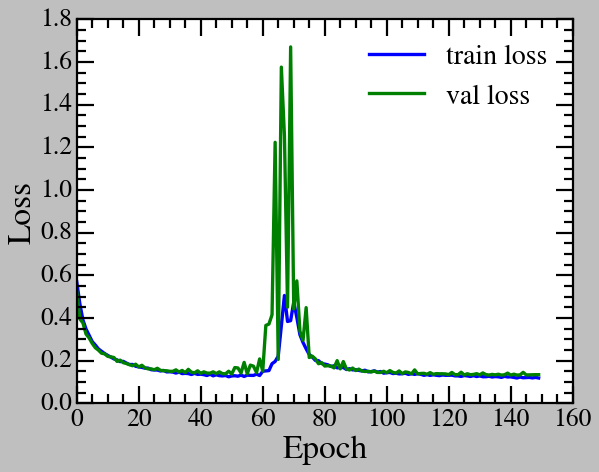

In [41]:
plt.plot(training_stats['train_losses'], label='train loss')
plt.plot(training_stats['val_losses'], label='val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

#plt.yscale('log')

plt.legend()
plt.show()

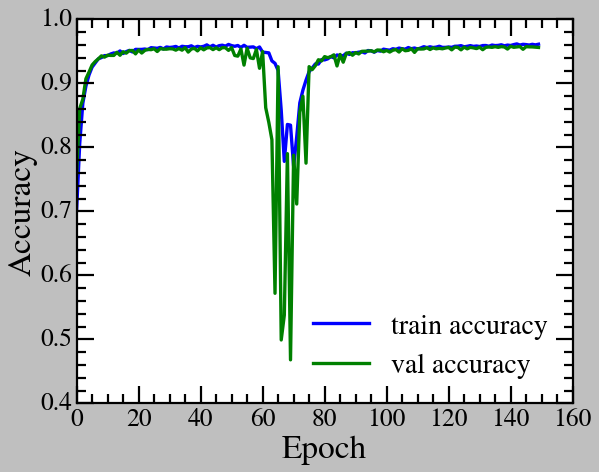

In [42]:
plt.plot(training_stats['train_accuracies'], label='train accuracy')
plt.plot(training_stats['val_accuracies'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

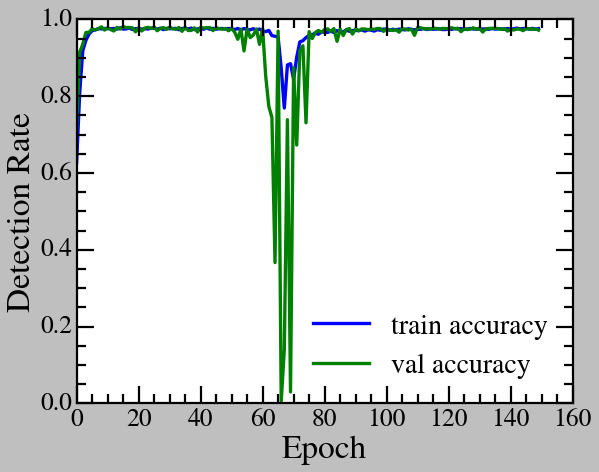

In [43]:
plt.plot(training_stats['train_P_detections'], label='train accuracy')
plt.plot(training_stats['val_P_detections'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('Detection Rate')

plt.legend()

plt.show()

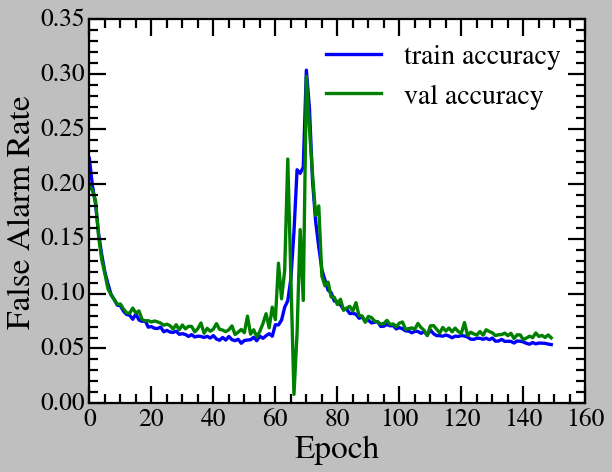

In [44]:
plt.plot(training_stats['train_P_false_alarms'], label='train accuracy')
plt.plot(training_stats['val_P_false_alarms'], label='val accuracy')

plt.xlabel('Epoch')
plt.ylabel('False Alarm Rate')

plt.legend()

plt.show()